# Semantic querying of earth observation data

Semantique (to be pronounced with sophisticated French accent) is a structured framework for semantic querying of earth observation data.

The core of a semantic query is the **query recipe**. It contains instructions that together formulate a recipe for inference of new knowledge. These instructions can be grouped into multiple **results**, each representing a distinct piece of knowledge. A semantic query recipe is different from a regular data cube query statement because it allows you to refer directly to real-world concepts by their name, without having to be aware how these concepts are actually represented by the underlying data, and all the technical implications that come along with that. For example, you can ask how often *water* was observed at certain locations during a certain timespan, without the need to specify the rules that define how the collected data should be used to infer if an observation can actually be classified as being *water*. 

These rules are instead specified in a separate component which we call the **ontology**. It maps *a priori* knowledge of the real world to the data values in the image domain. Hence, an ontology is a repository of rulesets. Each ruleset uniquely defines a **semantic concept** that exists in the real world, by formulating how this concept is represented by collected data (which may possibly be [semantically enriched](https://doi.org/10.3390/data4030102) to some extent). Usually, these rules describe a binary relationship between the data values and the semantic concepts (i.e. the rules can be evaluated to either "true" or "false"). For example: 

> IF data value a > x AND data value b < y THEN water

The data and information layers are stored together in a **factbase**. A factbase is described by its layout, which is a repository of metadata objects. Each metadata object describes the content of a specific **resource** of data or information.

An ontology and a factbase should be provided when executing a semantic query recipe, together with the spatio-temporal extent in which the query should be evaluated. The query recipe itself is independent from these components. To some extent, at least. Of course, when you refer to a concept named "water" in your query recipe, it can only be executed alongside an ontology that defines how "water" can be represented by collected data, and a factbase that acutally contains these data. Unfortunately, we can't do magic.. However, the query recipe itself does not contain any information nor cares about how "water" is defined, and all the technical details that come along with that. There is a clear separation between the *definitions of the concepts* (these are stored as rules in the ontology) and *how these definitions are applied to infer new knowledge* (this is specified as instructions in the query recipe). 

That also means that query recipes remain fairly stable even when concepts are defined in a different way. For example, if we have a new technique to utilize novel data source for water detection from space, the factbase and the ontology change. The factbase needs to contain these novel data sources, and the ontology needs to implement rules that use the new technique for water detection. However, the query *how often was water observed* remains the same, since in itself it does not contain any information on how water is defined. This is in line with the seperation between the *world domain* and the *image domain*. Concepts in the world domain are fairly stable, while data and techniques in the image domain constantly change.

Hence, the explicitly separated structure makes the semantic EO data querying process as implemented in semantique different from regular EO data querying, where this separation is usually not clear, and the different components are weaved together into a single query statement. Thanks to this structure, semantique is useful for those user groups that lack the advanced technical knowledge of EO data, but can benefit from the applications of it in their specific domain. Furthermore, it eases interoperability of EO data analysis workflows, also for expert users.

This notebook introduces the semantique package and provides basic examples of how to use it in a common semantic querying workflow.

## Content

- [Components](#Components)
    - [The query recipe](#The-query-recipe)
    - [The factbase](#The-factbase)
    - [The ontology](#The-ontology)
    - [The spatio-temporal extent](#The-spatio-temporal-extent)
    - [Additional configuration parameters](#Additional-configuration-parameters)
- [Processing](#Processing)

## Prepare

Import the semantique package:

In [1]:
import semantique as sq

Import other packages we will use in this demo:

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json

## Components

In semantique, a semantic query is processed by a query processor, with respect to a given ontology and factbase, and within the bounds of a given spatio-temporal extent. Below we will describe in more detail how semantique allows you to construct the required components for query processing.

### The query recipe

The first step in the semantic querying process is to construct the query recipe for inference of new knowledge. That is, you have to write *instructions* that tell the query processor what steps it should take to obtain your desired result. In semantique you can do this in a flexible manner, by combining basic building blocks with each other. Each building block represents a specific component of a result instruction, like a reference to a semantic concept or a certain processing task.

We start with an empty query recipe:

In [3]:
recipe = sq.QueryRecipe()

Such a [`QueryRecipe`](https://zgis.github.io/semantique/_generated/semantique.QueryRecipe.html) object has the same structure as a dictionary, with each element containing the instructions for a specific result. You can request as many results as you want. 

Now we have to fill the empty query recipe by adding the instructions for all of our desired results one by one to our initialized recipe object. We do this by combining semantique's building blocks together in **processing chains**. A processing chain always has a *with-do structure*. 

In the *with* part, you attach a block that contains a **reference** to an object that contains data or information. We call this the *input object* of the processing chain. The query processor will evaluate this reference into a multi-dimensional array containing a set of data values, and usually having at least a spatial and a temporal dimension. Each cell in this array is called a *pixel* and represents an observation on a specific location in space at a specific moment in time. We also call the array a **data cube**. 

In most cases the reference in the *with* part of the processing chain will be a reference to a real-world semantic concept defined in an ontology. If the rules in the ontology describe *binary relationships* between the semantic concepts and the pixel values, the corresponding data cube will be boolean, with "true" values (i.e. 1) for those pixels that are identified as being an observation of the referenced concept, and "false" values (i.e. 0) for all other pixels in the spatio-temporal extent. In the [References notebook](references.ipynb) you can find an overview of all other types of references a processing chain may start with.

In the *do* part, you specify one or more **actions** that should be applied to the input object. Each action is a well-defined data cube operation that performs a *single* task. For example, applying a function to each pixel of a data cube, reducing a particular dimension of a data cube, filtering the pixels of a data cube based on some condition, et cetera. Each building block that represents such an action is labeled by an action word that should intuitively describe the operation it performs. Therefore we also call these type of building blocks **verbs**. In the [Verbs notebook](verbs.ipynb) you can find an overview of all implemented verbs and their functionalities.

> WITH input_object DO apply_first_action THEN apply_second_action THEN apply_third_action

So let's show a basic example of how to construct such a processing chain. You can refer to any semantic concept by using the [`concept`](https://zgis.github.io/semantique/_generated/semantique.concept.html#semantique.concept) function. How to specify the reference, depends on the structure of the ontology that the query will be processed against. Usually, an ontology does not only list rulesets of semantic concepts, but also formalizes a categorization of these concepts. That is, a reference to a specific semantic concept usually consists of the name of that concept, *and* the name of the category it belongs to. Optionally there can be multiple hierarchies of categories, for example to group concepts of different semantic levels (e.g. an entity *water body* is of a lower semantic level than an entity *lake*, since lake is by definition always a water body, but a water body not necessarily a lake). See the [Ontology section](#The-ontology) for details. The [`concept`](https://zgis.github.io/semantique/_generated/semantique.concept.html#semantique.concept) function lets you specify as many levels as you need, starting with the lowest-level category, and ending with the name of the semantic concept itself.

The common lowest-level categorization groups the semantic concepts into very abstract types. For example, a semantic concept might be an *entity* (a phenonemon with a distinct and independent *existence*, e.g. a forest or a lake) or an *event* (a phenonemon that *takes place*, e.g. a fire or a flood). If the semantic concepts are stored as direct element of these lowest-level categories without any further subdivision, we can refer to a semantic concept such as *water body* as follows.

> **NOTE** <br/> Currently we only focus on pixel based queries. Hence, the query processor evaluates for each pixel if the observed phenonemon in that pixel is *part of* a given entity or not, considering only the data value of the pixel itself. The semantique framework is flexible enough to also support object-based approaches. In that case te rulesets of concepts should look further than only individual pixels. Creating such rulesets is still a challenge..

In [4]:
water = sq.concept("entity", "water")
print(json.dumps(water, indent = 2))

{
  "type": "concept",
  "reference": [
    "entity",
    "water"
  ]
}


If you use ontologies that include sub-categories, you can simply use the same function to refer to them, in a form as below. There is no limit on how many sub-categories you can use in a reference. Of course, this all depends on the categorization of the ontology that you will use.

In [5]:
lake = sq.concept("entity", "natural_entities", "water_bodies", "lake")

Note that each reference is nothing more than a textual reference. At the construction stage, no data processing is done at all. More specifically: the reference is an object of class [`CubeProxy`](https://zgis.github.io/semantique/_generated/semantique.CubeProxy.html), meaning that it will be evaluated into a data cube, but only when executing the query recipe.

In [6]:
type(water)

semantique.blocks.CubeProxy

For convenience, commonly used lowest-level semantic concept categories (e.g. entities) are also implemented as separate construction functions, such that you can call them directly. Hence, the code below produces the same output as above.

In [7]:
water = sq.entity("water")
print(json.dumps(water, indent = 2))

{
  "type": "concept",
  "reference": [
    "entity",
    "water"
  ]
}


The *do* part of the processing chain can be formulated by applying the actions as methods to the input object. Just an in the *with* part, this will not perform any action just yet. It only constructs the textual recipe for the result, which will be executed at the processing stage. 

The code below shows a simple set of instructions that form the recipe for a result. The instructions consist of a single processing chain, starting with a reference to the concept "water", and subsequently applying a single action to it. During processing, this will be evaluated into a two dimensional data cube with for each location in space the number of times water was observed. Right now, it is nothing more than a textual recipe.

In [8]:
water_count = sq.entity("water").reduce("time", "count")
print(json.dumps(water_count, indent = 2))

{
  "type": "processing_chain",
  "with": {
    "type": "concept",
    "reference": [
      "entity",
      "water"
    ]
  },
  "do": [
    {
      "type": "verb",
      "name": "reduce",
      "params": {
        "dimension": "time",
        "reducer": "count"
      }
    }
  ]
}


Instead saving result instructions as separate objects, we include them as an element in our recipe object. We can include as many result instructions in a single query as we want.

In [9]:
recipe["water_map"] = sq.entity("water").reduce("time", "count")
recipe["vegetation_map"] = sq.entity("vegetation").reduce("time", "count")
recipe["water_time_series"] = sq.entity("water").reduce("space", "percentage")

You can apply as many actions as you want simply by adding more actions blocks to the chain.

In [10]:
recipe["avg_water_count"] = sq.entity("water").\
    reduce("time", "count").\
    reduce("space", "mean")

Some of the action blocks allow to join information from other objects into the active evaluation object. For example, instead of only calculating the water count as shown above, we might be interested in the summed count of the concepts water and vegetation. Such an instruction can be modelled by nesting multiple processing chains.

In [11]:
recipe["summed_count"] = sq.entity("water").\
    reduce("time", "count").\
    evaluate("add", sq.entity("vegetation").reduce("time", "count"))

Again, it is important to notice that the query construction phase does not include *any* loading nor analysis of data or information. It simply creates a textual query recipe, which will be executed at a later stage. The query we constructed in all the examples above looks like [this](https://github.com/ZGIS/semantique/blob/main/demo/files/recipe.json).

We can export and share this query recipe as a JSON file.

In [12]:
with open("files/recipe.json", "w") as file:
    json.dump(recipe, file, indent = 2)

### The factbase

The factbase is the place where the raw EO data and possibly derived information layers are stored. As mentioned before, the factbase is supposed to have a *layout* file that describes its content. This file has a dictionary-like structure. Each of its elements is again a dictionary, and represents the highest-level category of resources. This nested, hierarchical structure continues depending on the amount of sub-categories, until the point where you reach a metadata object belonging to a specific resource. It summarizes the data values of that resource, and also contains information on where to find this resource inside the storage structure of the factbase. Unless you create your own factbase, you will usually not write a layout file from scratch. Instead, the factbase you are using should already come with a layout file.

Semantique utilizes the layout file to create an internal model of the factbase. It pairs it with a **retriever function**. This function is able to read a reference to a specific resource, lookup its metadata object in the layout file, and use these metadata to retrieve the corresponding data values as a data cube from the actual data storage location.

However, the exact structure of a layout file (i.e. what metadata keys it exactly contains), as well as the way the retriever function has to retrieve the actual data values, heavily depends on the format of the data storage. Data may be stored on a database server utilizing some specific database management system, simply as files on disk, or whatever else.

Therefore, semantique offers a flexible structure in which different factbase formats are modelled by different classes, with different retriever functions. All these classes inherit from an abstract base class named [`Factbase`](https://zgis.github.io/semantique/_generated/semantique.factbase.Factbase.html#semantique.factbase.Factbase), which serves a general template for how a factbase should be modelled.

Currently semantique contains two built-in factbase formats. The first one is called [`Opendatacube`](https://zgis.github.io/semantique/_generated/semantique.factbase.Opendatacube.html) and is tailored to usage with the EO specific [OpenDataCube](https://www.opendatacube.org/) database management system. This class has a OpenDataCube-specific retriever function that knows exactly how to retrieve data from this system. You would initialize an instance from this class as by providing it the layout file, as well as an OpenDataCube connection object. This object allows the retriever function to connect with the database server an actually retrieve data from it. Probably all factbase formats that store the data on a server will need such kind of a connection object.

```python
factbase = sq.factbase.Opendatacube(layout, connection = datacube.Datacube())
```

The second one is called [`GeotiffArchive`](https://zgis.github.io/semantique/_generated/semantique.factbase.GeotiffArchive.html) and has a much simpler format that assumes each resource is stored as a GeoTIFF file within a single ZIP archive. This class contains a retriever function that knows how to load GeoTIFF files as multi-dimensional arrays in Python, and how to subset (and possibly also resample and/or reproject) them to a given spatio-temporal extent. Instead of a database connection, we provide the initializer with the location of the ZIP file in which the resources are stored.

```python
factbase = sq.factbase.GeotiffArchive(layout, src = "foo.zip")
```

In the future more built-in factbase formats might be added, but as user you can also write your own class for a specific factbase format that you use. See the [Advanced usage notebook](https://zgis.github.io/semantique/_notebooks/advanced.html#Creating-custom-factbase-classes) for details. It is important to note that the query processor does not care at all what the format of the factbase is and how resources are retrieved from the factbase. It only cares about what input the retriever function accepts, and in what format it returns the retrieved resource.

In our examples we will use the simpler [`GeotiffArchive`](https://zgis.github.io/semantique/_generated/semantique.factbase.GeotiffArchive.html) factbase format. We have a set of [example resources](https://github.com/ZGIS/semantique/blob/main/demo/files/resources.zip) for a tiny [spatial extent](https://github.com/ZGIS/semantique/blob/main/demo/files/footprint.json) and only three different timestamps, as well as a [layout file](https://github.com/ZGIS/semantique/blob/main/demo/files/factbase.json) that contains all necessary metadata entries the retriever function of this format needs.

In [13]:
with open("files/factbase.json", "r") as file:
    layout = json.load(file)

In [14]:
factbase = sq.factbase.GeotiffArchive(layout, src = "files/resources.zip")

The retriever function is a method of this factbase instance, which will internally be called by the query processor whenever a specific resource is referenced.

In [15]:
hasattr(factbase, "retrieve")

True

### The ontology

The ontology plays an essential role in the semantic querying framework. It serves as the mapping between the image-domain and the real-world domain. That is, it contains rulesets that define how real-world concepts and their properties are represented by the data in the factbase. By doing that, it also formalizes how concepts are categorized and how the relations between multiple concepts and/or their properties are structured. 

These rulesets are stored in a dictionary-like structure. Each of its elements is again a dictionary, and represents the highest-level category of concepts. This nested, hierarchical structure continues depending on the amount of sub-categories, until the point where you reach a ruleset defining a specific concept.

In semantique, an ontology is always paired with a **translator function**. This function is able to read a reference to a specific concept, lookup its ruleset object in the ontology, and use these rules to translate the reference into a data cube. When the rules describe *binary relationships* between the semantic concepts and the data values, this data cube will be boolean, where pixels that are identified as being an observation of the concept get a a "true" value (i.e. 1), and the other pixels get a "false" value (i.e. 0).

However, the way the rules are specified, and therefore also the way they should be evaluated by the translator function, are not fixed. Basically, you can do this in any way you want. For example, your rules could be a set of parameters for a given machine learning model, and your translator a function that knows how to run that model with those parameters. Your rules could also be paths or download links to some Python scripts, and your translator a function that knows how to execute these scripts. Hence, just as the factbase models described before, the ontology models in semantique can have many different formats.

Therefore, semantique offers a flexible structure in which different ontology formats are modelled by different classes, with different translator functions. All these classes inherit from an abstract base class named [`Ontology`](https://zgis.github.io/semantique/_generated/semantique.ontology.Ontology.html), which serves a general template for how an ontology should be modelled. Currently there is only one built-in ontology format in semantique, called (unsurprisinly) [`Semantique`](https://zgis.github.io/semantique/_generated/semantique.ontology.Semantique.html). We will introduce this format below. As a user you can also write your own class for a specific ontology format that you use by inheriting from the abstract [`Ontology`](https://zgis.github.io/semantique/_generated/semantique.ontology.Ontology.html) class. See the [Advanced usage notebook](https://zgis.github.io/semantique/_notebooks/advanced.html#Creating-custom-ontology-classes) for details. It is important to note that the query processor does not care at all what the format of the ontology is and how it translated concept references. It only cares about what input the translator function accepts, and in what format it returns the translated concepts.

Back to the semantique specific ontology format. We can create an instance of it by providing a dictionary with rulesets that was shared with us. However, expert users can also create their own ontology from scratch. In that case, you'll start with an empty ontology, and iteratively fill it with rules afterwards:

In [16]:
ontology = sq.ontology.Semantique()

The translator function is a method of this ontology instance, which will internally be called by the query processor whenever a specific concept is referenced.

In [17]:
hasattr(ontology, "translate")

True

In this example, we will focus solely on defining entities, and use a one-layer categorization. That is, our only category is *entity*. The first step is to add this category as element to the ontology. Its value can still be an empty dictionary. We will add the concept definitions afterwards.

> **NOTE** <br/> The examples we use below are heavily simplified and don't always make sense, but are meant mainly to get an idea of how the package works.

In [18]:
ontology["entity"] = {}

Lets first look deeper into the structure of concept definitions. Each concept is defined by one or more named **properties** it has. For example, a entity *lake* may be defined by its *color* (a blueish, water-like color) in combination with its *texture* (it has an approximately flat surface). That is, the ruleset of a semantic concept definition is a set of distinct property definitions. 

Now, we need to construct rules that define a binary relationship between a property and the data values in the factbase. That is, the rules should define for each pixel in our data if it meets a specific property ("true"), or not ("false"). In the Semantique-format, we can do this by utilizing the same building blocks as we did for constructing our query recipe. The only difference is that a processing chain will now usually start with a reference to a factbase resource. During query processing, this reference will be send to the retriever function of the factbase, which will return a data cube filled with the requested data values. Then, pre-defined actions will be applied to this data cube. Usually these actions will encompass the evaluation of a comparison operator, in which the value of each pixel is compared to some constant (set of) value(s), reuturning a "true" value (i.e. 1) when the comparison holds, and a "false" value (i.e. 0) otherwise.

For example: we utilize the "Color type" resource to define if a pixel has a water-like color. This resource is a layer of semantically enriched data and contains categorical values. The categories with indices `21`, `22`, `23` and `23` correspond to color combinations that *appear* to be water. Hence, we state that a pixel meets the color property of a lake when its value in this "Color type" resource corresponds with one of the above mentioned indices. Furthermore, we state that a pixel meets the texture property of a lake when its value in the "slope" resource equals 0.

In [19]:
ontology["entity"]["lake"] = {
    "color": sq.appearance("Color type").evaluate("in", [21, 22, 23, 24]),
    "texture": sq.topography("slope").evaluate("equal", 0)
}

To define the entity, its property cubes are combined using an `all` operator. That means that a pixel is evaluated as being part of an entity if and only if it meets *all* properties of that entity.

Now we define a second entity *river*, which we say has the same color property of a lake, but instead has a non-zero slope.

> **NOTE** <br/> Different entities do not *need* to have the same properties defined.

In [20]:
ontology["entity"]["river"] = {
    "color": sq.appearance("Color type").evaluate("in", [21, 22, 23, 24]),
    "texture": sq.topography("slope").evaluate("not_equal", 0) 
}

As you see, there is a relation between the entities *lake* and *river*. They share a property. However, we defined the same property twice. This is not needed, because in the Semantique-format, you can always refer to other entities in your ontology, as well as to properties in these entities. In this way, you can intuitively model relations between different semantic concepts. Hence, the same *river* definition can also be structured as follows:

In [21]:
ontology["entity"]["river"] = {
    "color": sq.entity("lake", property = "color"),
    "texture": sq.entity("lake", property = "texture").evaluate("invert")
}

Or, to take it a step further, as below. Basically we are saying here that a *lake* has the color of *water* and the texture of a *plain* (again, we oversimplify here!).

In [22]:
ontology["entity"]["water"] = {
    "color": sq.appearance("Color type").evaluate("in", [21, 22, 23, 24]),
}

ontology["entity"]["vegetation"] = {
    "color": sq.appearance("Color type").evaluate("in", [1, 2, 3, 4, 5, 6]),
}

ontology["entity"]["plain"] = {
    "color": sq.entity("vegetation", property = "color"),
    "texture": sq.topography("slope").evaluate("equal", 0) 
}

ontology["entity"]["lake"] = {
    "color": sq.entity("water", property = "color"),
    "texture": sq.entity("plain", property = "texture")
}

ontology["entity"]["river"] = {
    "color": sq.entity("water", property = "color"),
    "texture": sq.entity("plain", property = "texture").evaluate("invert")
}

We can also model relationships in a way where some entity is the union of other entities.

In [23]:
ontology["entity"]["natural_area"] = {
    "members": sq.collection(sq.entity("water"), sq.entity("vegetation")).merge("or")
}

It is also possible to include temporal information. For example, we only consider an observation to be part of a lake when over time more than 80% of the observations at that location are identified as water, excluding those observations that are identified as a cloud.

In [24]:
ontology["entity"]["lake"] = {
    "color": sq.entity("water", property = "color"),
    "texture": sq.entity("plain", property = "texture"),
    "continuity": sq.entity("water", property = "color").\
        filter(sq.entity("cloud").evaluate("invert")).\
        reduce("time", "percentage").\
        evaluate("greater", 80)
}

The flexible structure with the building blocks of semantique make many more structures possible. Now you have an idea of how to construct and ontology from scratch using the built-in Semantique-format, we move on and construct a complete ontology in one go. We use simpler rulesets as above, since our demo factbase only contains a very limited set of resources.

In [25]:
ontology = sq.ontology.Semantique()
ontology["entity"] = {}

ontology["entity"]["water"] = {"color": sq.appearance("Color type").evaluate("in", [21, 22, 23, 24])}
ontology["entity"]["vegetation"] = {"color": sq.appearance("Color type").evaluate("in", [1, 2, 3, 4, 5, 6])}
ontology["entity"]["builtup"] = {"color": sq.appearance("Color type").evaluate("in", [13, 14, 15, 16, 17])}
ontology["entity"]["cloud"] = {"color": sq.atmosphere("Color type").evaluate("equal", 25)}
ontology["entity"]["snow"] = {"color": sq.appearance("Color type").evaluate("in", [29, 30])}

Our constructed ontology looks like [this](https://github.com/ZGIS/semantique/blob/main/demo/files/ontology.json). We can export and share this ontology as a JSON file.

In [26]:
with open("files/ontology.json", "w") as file:
    json.dump(ontology, file, indent = 2)

That also means that as non-expert we don't have to worry about constructing our own ontology from scratch. We can simply load a shared ontology in the same way as we loaded the layout file of the factbase, and construct the ontology object accordingly.

In [27]:
with open("files/ontology.json", "r") as file:
    rules = json.load(file)

ontology = sq.ontology.Semantique(rules)

### The spatio-temporal extent

Semantic query recipes are general recipes for inference of new knowledge. In theory, they are not restricted to specific areas or specific timespans. However, the recipes are executed with respect to given spatio-temporal bounds. That is, we need to provide both a spatial and temporal extent when executing a semantic query recipe.

To model a spatial extent, semantique contains the [`SpatialExtent`](https://zgis.github.io/semantique/_generated/semantique.extent.SpatialExtent.html) class. An instance of this class can be initialized by providing it any object that can be read by the [`GeoDataFrame`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html) initializer of the [geopandas](https://geopandas.org/en/stable/) package. Any additional keyword arguments will be forwarded to this initializer. In practice, this means you can read any GDAL-supported file format with [`geopandas.read_file`](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html), and then use that object to initialize a spatial extent. In this demo we use a small, rectangular area around Zell am See in Salzbuger Land, Austria.

In [28]:
geodf = gpd.read_file("files/footprint.geojson")
geodf.explore()

In [29]:
space = sq.SpatialExtent(geodf)

To model a temporal extent, semantique contains the [`TemporalExtent`](https://zgis.github.io/semantique/_generated/semantique.extent.TemporalExtent.html) class. An instance of this class can be initialized by providing it the first timestamp of the timespan, and the last timestamp of the timespan. The given interval is treated as being closed at both sides.

In [30]:
time = sq.TemporalExtent("2019-01-01", "2020-12-31")

Just as with the spatial extent, there is a lot of flexibility in how you can provide your timestamps. You can provide dates in formats as `"2020-12-31"` or `"2020/12/31"`, but also complete ISO8601 timestamps such as `"2020-12-31T14:37:22"`. As long as the [`Timestamp`](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html) initializer of the [pandas](https://pandas.pydata.org/) package can understand it, it is supported by semantique. Any additional keyword arguments will be forwarded to this initializer.

### Additional configuration parameters

The last thing we have left before executing our semantic query recipe, is to define some additional configuration parameters. This includes the desired coordinate reference system (CRS) in which spatial coordinates should be represented, as well as the time zone in which temporal coordinates should be represented. You should also provide the desired spatial resolution of your output, as a list containing respectively the y and x resolution in CRS units (i.e. usually meters for projected CRS and degrees for geographic CRS) and including direction. Note that for most CRS, that means that the first value (i.e. the y-value) of the resolution will always be negative.

There are also other configuration parameters that can be included to tune the behaviour of the query processor. See the [Advanced usage notebook](advanced.ipynb) for details.

In [31]:
config = {"crs": 3035, "tz": "UTC", "spatial_resolution": [-10, 10]}

## Processing

Now we have all components constructed, we are ready to execute our semantic query recipe. Hooray! This step is quite simple. You call the [`execute`](https://zgis.github.io/semantique/_generated/semantique.QueryRecipe.execute.html#semantique.QueryRecipe.execute) method of our recipe object, and provide it the factbase object, the ontology object, the spatial and temporal extents, and the additional configuration parameters. Then, just be a bit patient...  Internally, the query processor will solve all references, evaluate them into data cubes, and apply the defined actions to them. In the [Advanced usage notebook](https://zgis.github.io/semantique/_notebooks/advanced.html#The-query-processor-class) the implementation of query processing is described in some more detail.

In [32]:
config["track_types"] = False
response = recipe.execute(factbase, ontology, space, time, **config)

The response of the query is a dictionary which one element per result.

In [33]:
for key in response.keys():
    print(key)

water_map
vegetation_map
water_time_series
avg_water_count
summed_count


Each result is stored as an instance of the [`DataArray`](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray) class from the [xarray](https://docs.xarray.dev/en/stable/) package, which serves as the backbone for most of the analysis tasks the query processor performs.

In [34]:
for x in response.values():
    print(type(x))

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


The dimensions the arrays depend on the actions that were called in the result instruction. Some results might only have spatial dimensions (i.e. a map).

In [35]:
response["water_map"]

<xarray.DataArray 'water_map' (y: 563, x: 576)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
    feature       (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * y             (y) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
  * x             (x) float64 4.53e+06 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06

Other results might only have the temporal dimension (i.e. a time series).

In [36]:
response["water_time_series"]

<xarray.DataArray 'water_time_series' (time: 3)>
array([ 0.        , 13.81611407, 24.2398732 ])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0

And other results might even be dimensionless (i.e. a single aggregated value).

In [37]:
response["avg_water_count"]

<xarray.DataArray 'avg_water_count' ()>
array(0.38055987)
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0

There may also be results that contain both the spatial and temporal dimension, as well as results that contain an additonal, thematic dimension.

Since the result objects are [`DataArray`](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray) objects, we can use xarray for any further processing, and also to visualize the results. Again, see the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more details on what that package has to offer (which is a lot!). For now, we will just plot some of our obtained results to give an impression. In the [Gallery notebook](gallery.ipynb) you can find much more of such examples.

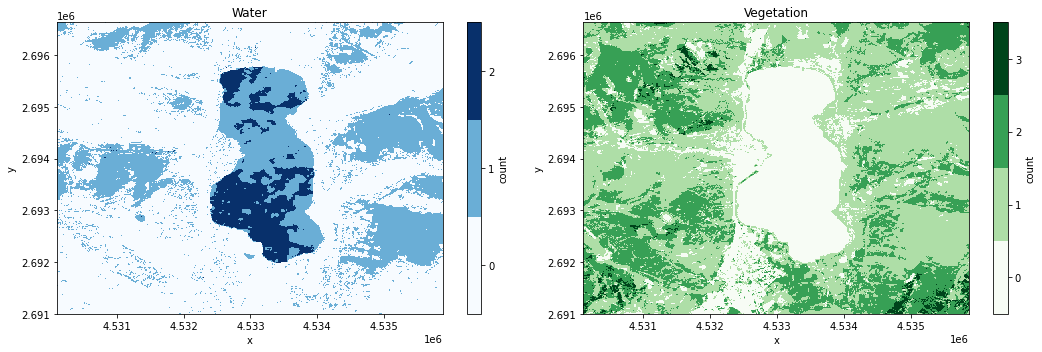

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

water_count = response["water_map"]
values = list(range(int(np.nanmin(water_count)), int(np.nanmax(water_count)) + 1))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = plt.cm.Blues
water_count.plot(ax = ax1, levels = levels, cmap = colors, cbar_kwargs = {"ticks": values, "label": "count"})
ax1.set_title("Water")

vegetation_count = response["vegetation_map"]
values = list(range(int(np.nanmin(vegetation_count)), int(np.nanmax(vegetation_count)) + 1))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = plt.cm.Greens
vegetation_count.plot(ax = ax2, levels = levels, cmap = colors, cbar_kwargs = {"ticks": values, "label": "count"})
ax2.set_title("Vegetation")

plt.tight_layout()
plt.draw()

Do note how the water count map contains many pixels that are counted as water but are clearly not water in the real world. Instead, these pixels correspond to observations in the shadow of a mountain. The color of water and shadow on a satellite image is very similar. Since in our ontology we only defined water based on its *color* property, it cannot differtiate it from shadow. This shows how important it is for accurate results to use multiple properties in entity definitions!